# Measurement Noise Estimation

This tutorial demonstrates how to estimate the measurement noise standard deviation for each sensor using a Gaussian Process model.

In [1]:
import os

import gpflow as gpf
import numpy as np
import tensorflow as tf

from tsipy.correction import SignalGenerator
from tsipy.fusion import SVGPModel, LocalGPModel
from tsipy.fusion.kernels import MultiWhiteKernel
from tsipy.fusion.utils import (
    build_and_concat_label_mask,
    build_and_concat_label_mask_output,
)
from tsipy.utils import (
    make_dir,
    plot_signals,
    plot_signals_and_confidence,
    pprint,
    pprint_block,
    sort_inputs,
)

## Parameters

In [2]:
random_seed = 0
normalization = False # If this is True, then estimated stds need re-scaling
clipping = True
num_inducing_pts = 500
max_iter = 5000

noise_std_a_rate = 0.040
noise_std_b_rate = 0.015

## Generate Dataset

In [3]:
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Generate Brownian motion signal
signal_generator = SignalGenerator(
    y_center=0.0,
    add_degradation=False,
    noise_stds=(noise_std_a_rate, noise_std_b_rate),
)
# Noise added is proportional to the value range of the signal
noise_std_a = noise_std_a_rate * (np.max(signal_generator.y) - np.min(signal_generator.y))
noise_std_b = noise_std_b_rate * (np.max(signal_generator.y) - np.min(signal_generator.y))

t_a, a = signal_generator["a"]
t_b, b = signal_generator["b"]

pprint("Signal", level=0)
pprint("- t_a", t_a.shape, level=1)
pprint("- a", a.shape, level=1)

pprint("Signal", level=0)
pprint("- t_b", t_b.shape, level=1)
pprint("- b", b.shape, level=1)

Signal                                            
    - t_a                                         (90002,)
    - a                                           (90002,)
Signal                                            
    - t_b                                         (20127,)
    - b                                           (20127,)


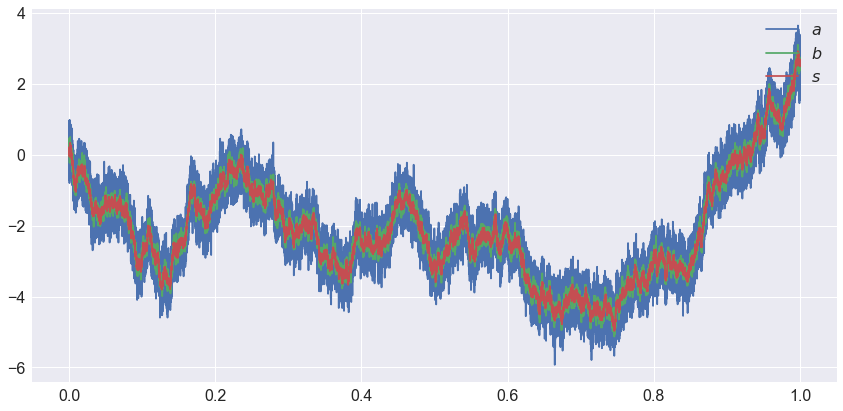

In [4]:
_ = plot_signals(
    [
        (t_a, a, "$a$", {}),
        (t_b, b, "$b$", {}),
        (signal_generator.x, signal_generator.y, "$s$", {}),
    ],
    legend="upper right",
)

## Sensor Fusion and Noise Estimation

In [5]:
gpf.config.set_default_float(np.float64)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

t_a = build_and_concat_label_mask(t_a, label=1)
t_b = build_and_concat_label_mask(t_b, label=2)
t_out = build_and_concat_label_mask_output(signal_generator.x)

# Concatenate signals and sort by x[:, 0]
t = np.vstack((t_a, t_b))
s = np.reshape(np.hstack((a, b)), newshape=(-1, 1))
t, s = sort_inputs(t, s, sort_axis=0)

pprint("Signals", level=0)
pprint("- t", t.shape, level=1)
pprint("- s", s.shape, level=1)

Signals                                           
    - t                                           (110129, 2)
    - s                                           (110129, 1)


### Fusion Model and Training

Sensor noise standard deviation is a parameter of `MultiWhiteKernel`. This parameter is learned during training.

In [6]:
# Kernels
matern_kernel = gpf.kernels.Matern12(active_dims=[0])
white_kernel = MultiWhiteKernel(labels=(1, 2), active_dims=[1])
kernel = matern_kernel + white_kernel

# Fusion model
model = SVGPModel(
    kernel=kernel,
    num_inducing_pts=num_inducing_pts,
    normalization=normalization,
    clipping=clipping,
)

# Train
model.fit(t, s, max_iter=max_iter, x_val=t_out, n_evals=5, verbose=True)

# Predict
s_out_mean, s_out_std = model(t_out)

pprint("\nOutput Signals", level=0)
pprint("- t_out", t_out.shape, level=1)
pprint("- s_out_mean", s_out_mean.shape, level=1)
pprint("- s_out_std", s_out_std.shape, level=1)

    - Step      1/5000:                           -527151.479
    - Step   1000/5000:                           -72688.766
    - Step   2000/5000:                           -35821.624
    - Step   3000/5000:                           -36876.176
    - Step   4000/5000:                           -31580.178
    - Step   5000/5000:                           -29128.483

Output Signals                                   
    - t_out                                       (100000, 2)
    - s_out_mean                                  (100000,)
    - s_out_std                                   (100000,)


## Results

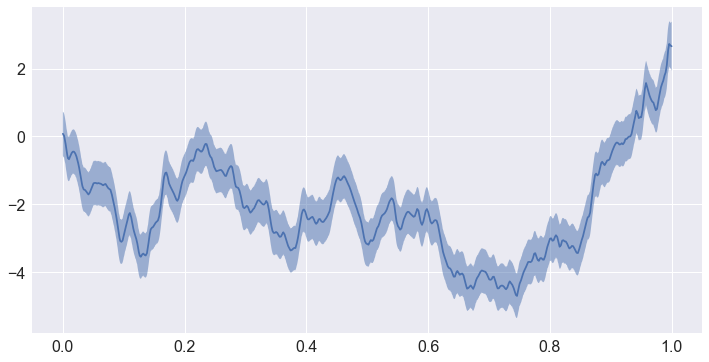

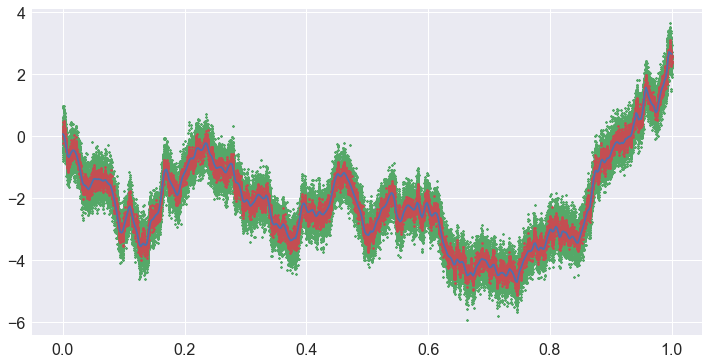

In [7]:
_ = plot_signals_and_confidence(
    [(t_out[:, 0], s_out_mean, s_out_std, "SVGP")],
)

fig, ax = plot_signals_and_confidence(
    [(t_out[:, 0], s_out_mean, s_out_std, "SVGP")],
)
ax.scatter(
    t_a[:, 0],
    a,
    label="$a$",
    s=3,
)
_ = ax.scatter(
    t_b[:, 0],
    b,
    label="$b$",
    s=3,
)

### Noise standard deviation comparison

The measurement noise is underestimated. When training the GP, the model is not guaranteed to recover the exact measurement noise level. Given the selected kernel, the GP can treat part of the signal as noise. Similarly, the measurement noise is estimated to be greater for signal B, which is indeed not the case. Thus, one needs to be careful when making conclusion.

In [11]:
# Kernel at index 0 is the matern kernel
# Kernel at index 1 is the multi-white kernel
est_noise_stds = model._model.kernel.kernels[1].variances.numpy()

est_noise_std_a = est_noise_stds[0]
est_noise_std_b = est_noise_stds[1]

pprint("Sensor a", level=0)
pprint("- Ground-truth:", "{:.5f}".format(noise_std_a), level=1)
pprint("- Estimation:", "{:.5f}".format(est_noise_std_a), level=1)

pprint("Sensor b", level=0)
pprint("- Ground-truth:", "{:.5f}".format(noise_std_b), level=1)
pprint("- Estimation:", "{:.5f}".format(est_noise_std_b), level=1)

Sensor a                                          
    - Ground-truth:                               0.31556
    - Estimation:                                 0.00026
Sensor b                                          
    - Ground-truth:                               0.11834
    - Estimation:                                 0.00033


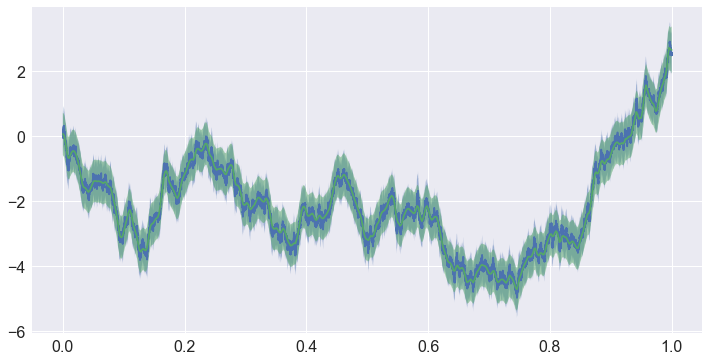

In [12]:
_, ax_a = plot_signals_and_confidence(
    [
        (
            signal_generator.x, 
            signal_generator.y, 
            noise_std_a * np.ones_like(signal_generator.y), 
            r"$\sigma_a$"
        ),
        (t_out[:, 0], s_out_mean, s_out_std, "SVGP"),
    ],
)

(-6.04577481468815, 3.9928228639266123)

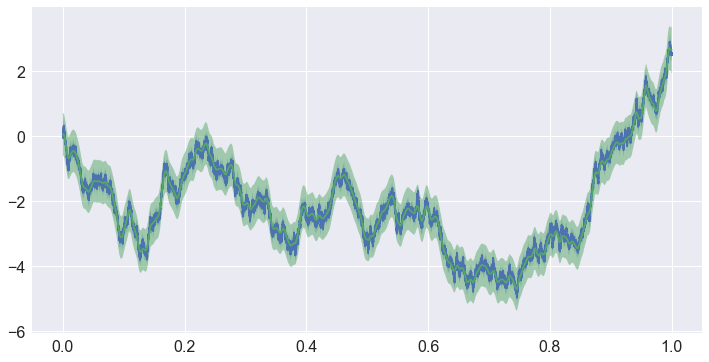

In [16]:
_, ax_b = plot_signals_and_confidence(
    [
        (
            signal_generator.x, 
            signal_generator.y, 
            noise_std_b * np.ones_like(signal_generator.y), 
            r"$\sigma_b$"
        ),
        (t_out[:, 0], s_out_mean, s_out_std, "SVGP"),
    ],
)
ax_b.set_ylim(*ax_a.get_ylim())